# Demonstration

In this demonstration, we show that EVA can be used interactively with Jupyter Notebooks.

1) User runs License plate recognition on video.

2) User sets a bounding box, to refine searches on number plates.

3) User gets these license plates and then runs LIKE operator on them to filter relevant results given by License Plate Recognition model.

### Download Files for Demonstration

1) Video data used - 
    Eva supports many popular Image and Video formats here we use
    - Closeup video of a car
    - 4K Video of a highway with traffic
2) EVA -
    Eva comes with an easy to use startup script which installs the necessary packages to run the `eva_server`
    - `00-start-eva-server.ipynb`
3) UDFs -
    To add additional functionality to the Database, Eva supports adding UDFs. These udfs could be Machine Learning models or just Python functions. In case of using Machine Learning UDFs, Eva also supports special python `decorator` to improve functionality.
    - We download an OCR UDF.

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
from IPython.core.magic import register_cell_magic
from eva.server.db_api import connect
import nest_asyncio

nest_asyncio.apply()
cursor = connect(host="127.0.0.1", port=5432).cursor()

@register_cell_magic
def evaql(line, cell):
    commands = cell.split(';')
    for command in commands[:-1]:
        cursor.execute(command)
        res = cursor.fetch_all()
        print(res)

In [3]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()
from IPython.core.magic import register_cell_magic


@register_cell_magic
def evaql(line, cell):
    commands = cell.split(';')
    for command in commands[:-1]:
        cursor.execute(command)
        res = cursor.fetch_all()
        print(res)

File ‘00-start-eva-server.ipynb’ already there; not retrieving.



In [4]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/ocr_extractor.py"
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/license_plate_extractor.py
!wget -nc "https://raw.githubusercontent.com/apoorva-dave/LicensePlateDetector/master/video12.mp4"

File ‘ocr_extractor.py’ already there; not retrieving.

File ‘license_plate_extractor.py’ already there; not retrieving.

File ‘video12.mp4’ already there; not retrieving.



### Register License Plate Extraction UDF

In [12]:
%%evaql
DROP UDF LicensePlateExtractor;
CREATE UDF IF NOT EXISTS LicensePlateExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  '/home/greatsage/projects/intern/gt/vldbdemo/workflows/notebooks/license_plate_extractor.py';

@status: ResponseStatus.FAIL
@batch: 
 None
@error: UDF LicensePlateExtractor does not exist, therefore cannot be dropped.
@status: ResponseStatus.SUCCESS
@batch: 
                                                                0
0  UDF LicensePlateExtractor successfully added to the database.
@query_time: 5.344771094999942


In [9]:
%%evaql
DROP TABLE IF EXISTS LicensePlateVideo;
DROP TABLE IF EXISTS TrafficVideo4k;
LOAD VIDEO "/home/greatsage/projects/intern/gt/vldbdemo/workflows/notebooks/video12.mp4" INTO LicensePlateVideo;
LOAD VIDEO "/home/greatsage/projects/intern/gt/vldbdemo/workflows/notebooks/traffic.webm" INTO TrafficVideo4k;

@status: ResponseStatus.SUCCESS
@batch: 
                                                0
0  Table Successfully dropped: LicensePlateVideo
@query_time: 0.2779465959999925
@status: ResponseStatus.SUCCESS
@batch: 
                                             0
0  Table Successfully dropped: TrafficVideo4k
@query_time: 0.20776333900005284
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 2.888653025999929
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 11.880637976999992


### License Plate Recognition

> We see that the model is not very good

In [7]:
query = 'SELECT LicensePlateExtractor(data) FROM LicensePlateVideo WHERE id=11;'
cursor.execute(query)
res = cursor.fetch_all()
print(res)

@status: ResponseStatus.SUCCESS
@batch: 
   licenseplateextractor.labels  \
0                [TSO7FX35341]   

                         licenseplateextractor.bboxes  \
0  [[[335, 768], [686, 768], [686, 841], [335, 841]]]   

  licenseplateextractor.scores  
0         [0.6573826378138632]  
@query_time: 20.82279919299981


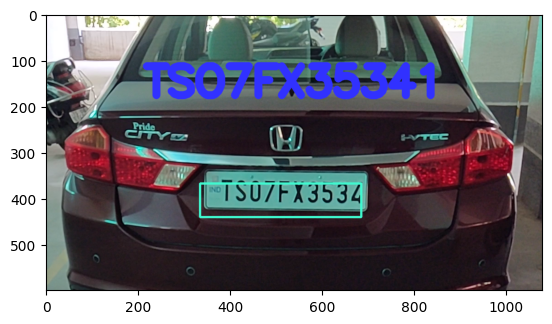

In [8]:
df = res.as_pandas()
annotate_license_video(df, "./video12.mp4")

### Adding a Region of Interest

     Focus on area of interest. This removes unwanted text detections and reduces computation

In [9]:
# using 4k Car video
query = 'SELECT * FROM TrafficVideo4k WHERE id=80;'
cursor.execute(query)
res = cursor.fetch_all()

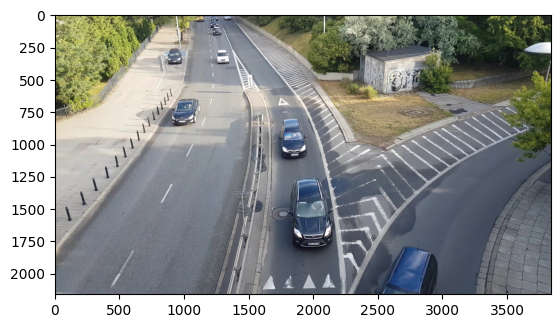

In [10]:
df2 = res.as_pandas()
img_show(res.as_pandas().iloc[0]['trafficvideo4k.data'])

In [11]:
# Create an region of interest
query = 'SELECT Crop(data, [1600,1600, 2250, 1800]) FROM TrafficVideo4k WHERE id=80 OR id=1000;'
cursor.execute(query)
res = cursor.fetch_all()

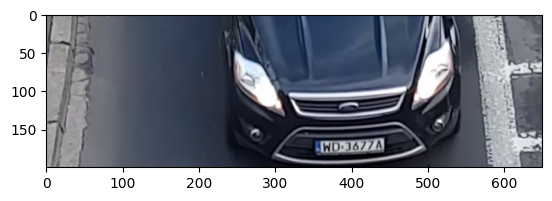

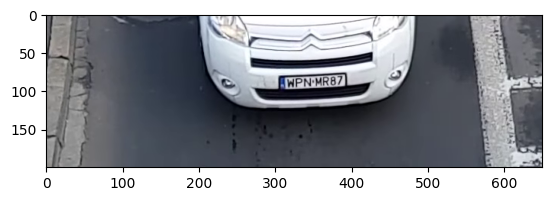

In [12]:
df2 = res.as_pandas()
img_show(df2.iloc[0]['crop.cropped_frame_array'])
img_show(df2.iloc[1]['crop.cropped_frame_array'])

In [13]:
query = 'SELECT Crop(data, [250, 750, 750, 900]) FROM LicensePlateVideo WHERE id=10;'
cursor.execute(query)
res = cursor.fetch_all()

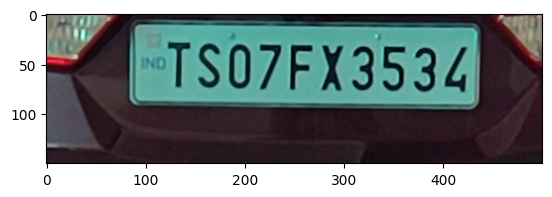

In [14]:
df2 = res.as_pandas()
img_show(df2.iloc[0]['crop.cropped_frame_array'])

### Further refining the predicate to get most relevant results

     Using LIKE operator to filter results from previous predicates

In [19]:
query = """
SELECT * FROM LicensePlateVideo 
JOIN LATERAL 
    LicensePlateExtractor(Crop(data, [250, 750, 750, 900])) AS X(label, x, y) 
WHERE label LIKE "[A-Z]{1,3}[0-9]{1,2}[A-Z]{1,2}[0-9]{1,4}";
"""
cursor.execute(query)
res = cursor.fetch_all()
res.as_pandas()

,licenseplateextractor.labels,licenseplateextractor.bboxes,licenseplateextractor.scores
0,[TSO7FX3534],"[[[335, 765], [682, 765], [682, 840], [335, 84...",[0.6327069069316315]


#### Using Matplotlib to plot output from the EVA query

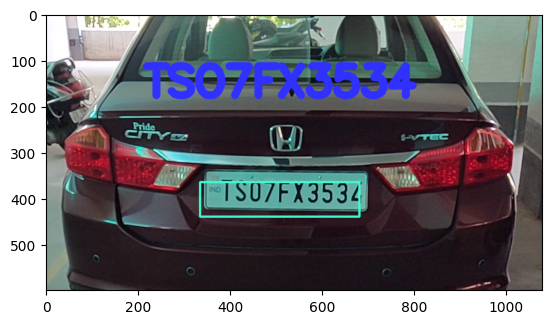

In [20]:
df = res.as_pandas()
annotate_license_video(df, "./video12.mp4")

## Important Fuctions

In [1]:
import cv2
import matplotlib.pyplot as plt

def annotate_license_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    x_offset = width * 0.2
    y_offset = height * 0.3

    while ret:

        df = detections
        df = df[['licenseplateextractor.bboxes', 'licenseplateextractor.labels']][df.index == frame_id]

        if df.size:

            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[frame_id][0], dfLst[frame_id][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])

                # object bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 

                # object label
                cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness * 4, cv2.LINE_AA) 
                y_offset = y_offset + height * 0.2
                
                # Show every fifth frame
                if frame_id % 5 == 0:
                    img_show(frame[400:1000, :])
        
        frame_id+=1
        ret, frame = vcap.read()

    vcap.release()

In [2]:
def img_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()